Imports

In [226]:
import numpy as np
import torch
from torchvision import datasets
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

Auxiliary Functions

In [227]:
# Auxiliary Functions

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
  e_x = torch.exp(x - torch.max(x, dim=1, keepdim=True))
  return e_x / e_x.sum(dim=1, keepdim=True)

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Label axes
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel='True label',
        xlabel='Predicted label',
        title='Confusion Matrix'
    )

    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add text labels inside the cells
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()


Manual Logistic Regression Implementation

In [246]:


class ManualLogisticRegression:
    def __init__(self, learning_rate = 1e-3, max_epochs=1000, tolerance = 1e-4, lambda_reg= 1e-3):
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.weights = None
        self.bias = None
        self.train_loss_history = []
        self.val_loss_history = []
        self.test_loss_history = []
        self.tolerance = tolerance
        self.lambda_reg = lambda_reg

    def loss_function(self, y_true, y_pred):
        epsilon = 1e-10
        cce = -torch.mean(torch.sum(y_true * torch.log(y_pred + epsilon), dim=1))
        l2_term = torch.sum(self.weights ** 2) * 0.5
        return cce + self.lambda_reg * l2_term


    def fit(self, x, y, x_val, y_val):
        # Initialize weights and bias
        n_features = 10
        image_size = 28 * 28
        self.weights = torch.randn(image_size, n_features, requires_grad=True)
        self.bias = torch.zeros(10, requires_grad=True)

        # Train
        for epoch in tqdm(range(self.max_epochs)):

            if self.weights.grad is not None and self.bias.grad is not None:
                self.weights.grad.zero_()
                self.bias.grad.zero_()

            # Forward
            y_pred = torch.matmul(x, self.weights) + self.bias
            y_pred = torch.softmax(y_pred, dim=1)       
            loss = self.loss_function(y_true=y, y_pred=y_pred)
            
            self.train_loss_history.append(loss.detach())

            # Backward
            loss.backward()

            with torch.no_grad():
                y_pred_val = torch.matmul(x_val, self.weights) + self.bias
                y_pred_val = torch.softmax(y_pred_val, dim=1)
                val_loss = self.loss_function(y_true=y_val, y_pred=y_pred_val)
                self.val_loss_history.append(val_loss.detach())

                # Parameter update with traditional Gradient Descent
                self.weights -= self.learning_rate * self.weights.grad
                self.bias -= self.learning_rate * self.bias.grad
            if epoch % 100 == 0:
                print(f"Epoch {epoch} | Loss = {loss:.4f} \n ")
            
            if torch.norm(self.weights.grad) < self.tolerance and torch.norm(self.bias.grad) < self.tolerance:
                print(f"Convergiu após {epoch + 1} iterações")
                break
    
    def predict(self, x):
        with torch.no_grad():
            y_pred = torch.matmul(x, self.weights) + self.bias
            y_pred = torch.softmax(y_pred, dim=1)
            return torch.argmax(y_pred, dim=1)
    
    def evaluate(self, x_true, y_true_labels):
        with torch.no_grad():
            y_pred_labels = self.predict(x=x_true)
            print(f"Accuracy: {accuracy_score(y_true_labels, y_pred_labels):.4f}")
            # cm = confusion_matrix(y_true_labels, y_pred_labels)
            # plot_confusion_matrix(cm, class_names=[str(i) for i in range(10)])
            return accuracy_score(y_true_labels, y_pred_labels)

                     

In [229]:
train_data = datasets.MNIST('./datasets', train=True)
test_data = datasets.MNIST('./datasets', train=False)

x_train = train_data.data.float().reshape(-1, 28 * 28) / 255.0
y_train_labels = train_data.targets

# one-hot encoding with 10 classes
y_train = torch.zeros(len(y_train_labels), 10)
y_train[torch.arange(len(y_train_labels)), y_train_labels] = 1

x_test = test_data.data.float().reshape(-1, 28 * 28) / 255.0
y_test_labels = test_data.targets
y_test = torch.zeros(len(y_test_labels), 10)
y_test[torch.arange(len(y_test_labels)), y_test_labels] = 1 


Dataset pre-processing

In [230]:
x_train = (x_train - x_train.mean())/ x_train.std()
x_test = (x_test - x_test.mean())/ x_test.std()

K-Fold CV

In [236]:
# each pixel has a weight associated with it. Initially, the weights need to be initialized

# size is the list size inside the weight matrix, it includes the weight of every pixel. Since there are 10 different possible labels, we will have 10 perceptrons
max_iter = 1300
learning_rate = 0.96
tolerance = 1e-3
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
print("---------------------------------------")
print(f"Learning rate: {learning_rate}")
kfold_accuracies = []
logreg = ManualLogisticRegression(learning_rate=learning_rate, max_epochs=max_iter, tolerance=tolerance)

for _, (train_index, validation_index) in enumerate(kf.split(x_train)):
  x_train_fold = x_train[train_index]
  y_train_fold = y_train[train_index]
  x_val_fold = x_train[validation_index]
  y_val_fold = y_train[validation_index]

  logreg.fit(x=x_train_fold, y=y_train_fold, x_val=x_val_fold, y_val=y_val_fold)

  y_val_fold_labels = torch.argmax(y_val_fold, dim=1)
  accuracy = logreg.evaluate(x_true=x_val_fold, y_true_labels=y_val_fold_labels)
  kfold_accuracies.append(accuracy)



print(f"Average accuracy: {torch.mean(torch.tensor(kfold_accuracies))}")
# final_f1 = f1_score(y_true=y_test_labels, y_pred=y_pred_labels, average='weighted')


plt.plot(logreg.train_loss_history, linewidth=2, label='Training Loss')
plt.plot(logreg.val_loss_history, linewidth=2, label='Validation Loss')
plt.plot(logreg.test_loss_history, linewidth=2)
plt.title('Training/Test Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

---------------------------------------
Learning rate: 0.96


  0%|          | 0/1300 [00:00<?, ?it/s]

Epoch 0 | Loss = 20.5012 
 


KeyboardInterrupt: 

Final Re-Training

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 | Loss = 24.2467 
 
Epoch 100 | Loss = 14.3540 
 
Epoch 200 | Loss = 9.7428 
 
Epoch 300 | Loss = 7.6765 
 
Epoch 400 | Loss = 6.7693 
 
Epoch 500 | Loss = 6.2378 
 
Epoch 600 | Loss = 5.8655 
 
Epoch 700 | Loss = 5.5772 
 
Epoch 800 | Loss = 5.3387 
 
Epoch 900 | Loss = 5.1333 
 


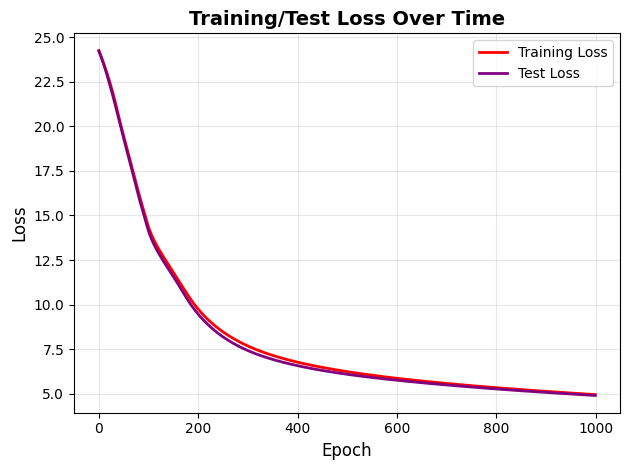

In [ ]:
# each pixel has a weight associated with it. Initially, the weights need to be initialized
learning_rate = 0.1
max_iter = 10000
# size is the list size inside the weight matrix, it includes the weight of every pixel. Since there are 10 different possible labels, we will have 10 perceptrons
logreg = ManualLogisticRegression(learning_rate=learning_rate, max_epochs=max_iter, tolerance=tolerance)
logreg.fit(x=x_train, y=y_train, x_val=x_test, y_val=y_test)


plt.plot(logreg.train_loss_history, linewidth=2, color='red', label='Training Loss')
plt.plot(logreg.val_loss_history, linewidth=2, color='purple', label='Test Loss')
plt.title('Training/Test Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Testagem do modelo

Accuracy: 0.5870
Test Accuracy: 0.587
Test F1-Score: 0.5859351591885033
Total Epochs: 1000


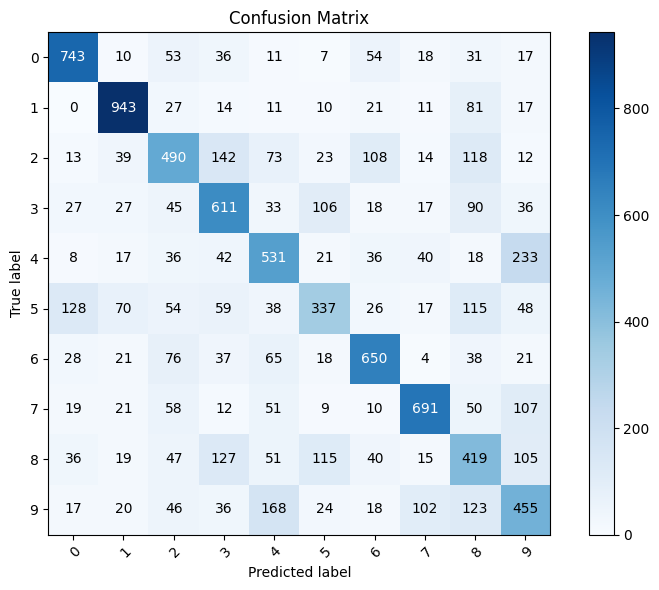

In [244]:
logreg.evaluate(x_true=x_test, y_true_labels=y_test_labels)

y_pred_labels = logreg.predict(x_test)


final_accuracy = accuracy_score(y_true=y_test_labels, y_pred=y_pred_labels)
final_f1 = f1_score(y_true=y_test_labels, y_pred=y_pred_labels, average='weighted')
print(f"Test Accuracy: {final_accuracy}")
print(f"Test F1-Score: {final_f1}")
print(f"Total Epochs: {len(logreg.val_loss_history)}")

cm = confusion_matrix(y_test_labels, y_pred_labels)
plot_confusion_matrix(cm, class_names=[str(i) for i in range(10)])
